In [6]:
# Cell 1 — Install deps (no XRootD needed)
!pip -q install "uproot>=5" awkward vector rich tqdm pandas pyarrow fastparquet matplotlib

In [7]:
import uproot
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt


In [8]:
FEATURES = [
"nMuon","nElectron","nJet","MET_pt","MET_phi","MET_sumEt",
"Muon_pt_0","Muon_eta_0","Muon_phi_0",
"Muon_pt_1","Muon_eta_1","Muon_phi_1",
"Electron_pt_0","Electron_eta_0","Electron_phi_0",
"Electron_pt_1","Electron_eta_1","Electron_phi_1",
"Jet_pt_0","Jet_eta_0","Jet_phi_0",
"Jet_pt_1","Jet_eta_1","Jet_phi_1",
"Jet_pt_2","Jet_eta_2","Jet_phi_2",
"Jet_pt_3","Jet_eta_3","Jet_phi_3",
"HT","ST","M_ll","M_jj_01","M_jj_12",
"delta_phi_MET_j0","delta_phi_MET_j1","min_delta_phi_MET_jets",
"delta_R_j0_j1","delta_phi_ll","delta_R_ll",
"Jet_btagDeepB_0","Jet_btagDeepB_1",
"MT_lep_MET","HT_ratio","MET_pt_HT_ratio",
"nJet_pt30","Jet_mass_0","LeadLepton_pt","sum_pt_leptons"
]


In [9]:
import uproot
import pandas as pd
import glob

def find_tree_recursive(file):
    """Find first TTree anywhere inside ROOT file."""
    for key, obj in file.items(recursive=True):
        if isinstance(obj, uproot.behaviors.TTree.TTree):
            return obj
    return None


def load_root_folder_chunked(
        folder,
        label,
        source,
        step_size=50000,
        max_files=None,
        max_events=None):

    files = sorted(glob.glob(folder + "/*.root"))
    if max_files:
        files = files[:max_files]

    dfs = []
    total_events = 0

    print(f"\nLoading {source} from {len(files)} files")

    for i, f in enumerate(files):

        print(f"  File {i+1}/{len(files)}")

        with uproot.open(f) as file:

            tree = find_tree_recursive(file)

            if tree is None:
                print("   No tree found, skipping")
                continue

            print("   Found tree:", tree.name)

            for batch in tree.iterate(
                    FEATURES,
                    library="pd",
                    step_size=step_size):

                batch["label"] = label
                batch["source"] = source
                dfs.append(batch)

                total_events += len(batch)

                if max_events and total_events >= max_events:
                    print(f"Reached event limit: {max_events}")
                    return pd.concat(dfs, ignore_index=True).iloc[:max_events]

    if len(dfs) == 0:
        print("No data loaded!")
        return pd.DataFrame()

    return pd.concat(dfs, ignore_index=True)


In [10]:
cmsderived = "/kaggle/input/datasets/katakuricharlotte/cms-derivedroot/derivedroot"
cms2016G   = "/kaggle/input/datasets/hiteshrs/cms2016g29-5785/processed_events"

dy   = load_root_folder_chunked(f"{cmsderived}/DYJetsToLL_0J_TuneCP5", 0, "DY", max_files=2)
wj   = load_root_folder_chunked(f"{cmsderived}/WJetsToLNu_TuneCP5", 0, "WJets", max_files=2)
tt   = load_root_folder_chunked(f"{cmsderived}/TTJets_TuneCP5", 0, "TT", max_files=2)
susy = load_root_folder_chunked(f"{cmsderived}/SMS-TChiWZ_ZToLL", 1, "SUSY", max_files=2)
real = load_root_folder_chunked(cms2016G, -1, "REAL", max_files=2)



Loading DY from 2 files
  File 1/2
   Found tree: Events
  File 2/2
   Found tree: Events

Loading WJets from 2 files
  File 1/2
   Found tree: Events
  File 2/2
   Found tree: Events

Loading TT from 2 files
  File 1/2
   Found tree: Events
  File 2/2
   Found tree: Events

Loading SUSY from 2 files
  File 1/2
   Found tree: Events
  File 2/2
   Found tree: Events

Loading REAL from 0 files
No data loaded!


In [11]:
df = pd.concat([dy, wj, tt, susy, real], ignore_index=True)

df_clean = df.copy()

print("Initial events:", len(df_clean))


Initial events: 11615070


In [12]:
import numpy as np

df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.dropna(inplace=True)

print("After NaN removal:", len(df_clean))


After NaN removal: 11615070


In [13]:
# transverse momenta upper bounds (detector realism)
df_clean = df_clean[
    (df_clean["MET_pt"] < 2000) &
    (df_clean["Jet_pt_0"] < 3000) &
    (df_clean["Muon_pt_0"] < 2000) &
    (df_clean["Electron_pt_0"] < 2000)
]

# eta detector acceptance
eta_cols = [c for c in df_clean.columns if "_eta_" in c]

for c in eta_cols:
    df_clean = df_clean[df_clean[c].abs() < 5]

print("After physics cleaning:", len(df_clean))


After physics cleaning: 11538158


In [14]:
df_clean = df_clean[
    (df_clean["nJet"] > 0) |
    (df_clean["nMuon"] > 0) |
    (df_clean["nElectron"] > 0)
]

print("After trivial-event removal:", len(df_clean))


After trivial-event removal: 11103638


In [15]:
baseline = df_clean[
    (df_clean["MET_pt"] > 50) &
    (df_clean["nJet"] >= 2) &
    (df_clean["HT"] > 200) &
    (df_clean["LeadLepton_pt"] > 20)
]

print("Baseline events:", len(baseline))


Baseline events: 659920


In [16]:
signal_region = baseline[
    (baseline["MET_pt"] > 200) &
    (baseline["HT"] > 400) &
    (baseline["nJet"] >= 3)
]

print("Signal region events:", len(signal_region))


Signal region events: 60638


In [17]:
control_region = baseline[
    (baseline["MET_pt"] < 100) &
    (baseline["HT"] < 300)
]

print("Control region events:", len(control_region))


Control region events: 118988


In [19]:
# Cell — Plot styling helper (define once)

import matplotlib as mpl

def paper_axes(ax,
              title=None,
              grid=True,
              grid_alpha=0.25,
              spine_width=1.2,
              tick_width=1.2,
              label_size=11,
              tick_size=10):
    """Lightweight 'paper' style formatting for a Matplotlib axis."""
    if title is not None:
        ax.set_title(title, fontsize=label_size + 1)

    # Spines
    for s in ax.spines.values():
        s.set_linewidth(spine_width)

    # Ticks
    ax.tick_params(axis="both", which="major", labelsize=tick_size,
                   width=tick_width, length=5, direction="in")
    ax.tick_params(axis="both", which="minor",
                   width=tick_width, length=3, direction="in")

    # Labels (keep whatever text you already set; just size them)
    ax.xaxis.label.set_size(label_size)
    ax.yaxis.label.set_size(label_size)

    # Grid
    if grid:
        ax.grid(True, which="major", alpha=grid_alpha, linewidth=0.8)
        ax.grid(True, which="minor", alpha=grid_alpha * 0.6, linewidth=0.5)

    return ax


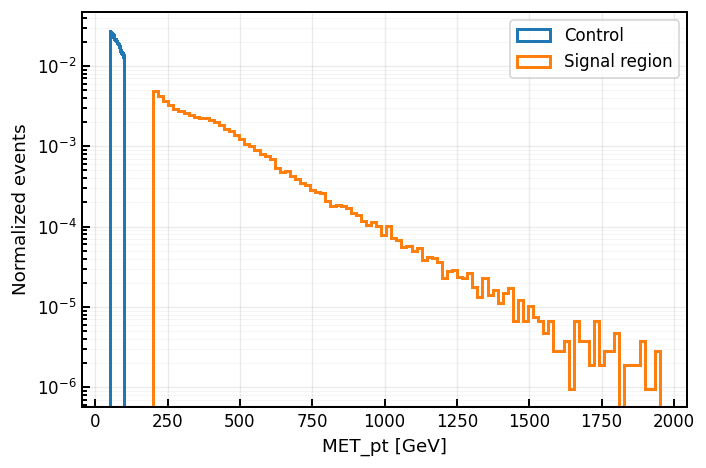

In [20]:
fig, ax = plt.subplots(figsize=(6,4), dpi=120)

ax.hist(control_region["MET_pt"], bins=100, histtype="step",
        linewidth=1.8, density=True, label="Control")

ax.hist(signal_region["MET_pt"], bins=100, histtype="step",
        linewidth=1.8, density=True, label="Signal region")

ax.set_yscale("log")
ax.set_xlabel("MET_pt [GeV]")
ax.set_ylabel("Normalized events")
ax.legend()

paper_axes(ax)
fig.tight_layout()

fig.savefig("/kaggle/working/signal_vs_control_met.jpg", dpi=300)
plt.show()


In [21]:
train_df = baseline[baseline["label"] != -1]

X = train_df.drop(columns=["label","source"])
y = train_df["label"]

print("Training events:", len(X))


Training events: 659920
